##### Copyright 2019 The TensorFlow Authors.

# Time series forecasting

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

#tf.enable_eager_execution()

#import keras

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import shutil
import plotly.graph_objs as go
import plotly
# Pyplot nodejs installieren!!
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### Speicher-Pfade festlegen und alte löschen
### NN - Paramerer festlegen

In [2]:
# Select a directory where saving the results
base_dir = './rnnV7.6'
file_writer_dir = '{}/logs'.format(base_dir)
save_model_dir = '{}/model'.format(base_dir)

# Delete the directory if existing
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
    pass
print(file_writer_dir)   

./rnnV7.6/logs


### Daten einlesen

In [33]:
df1 = pd.read_excel('./Urdaten/1_A&B_Gesamt_v2.xlsx', sheet_names='A_B_Gesamt', index_col='PeriodeKJ')
df2 = pd.read_excel('./Urdaten/2_AE-Erlös.xlsx', sheet_names='Auftragseingang Erlös', index_col='PeriodeKJ')
#df3 = pd.read_excel('./Urdaten/3_Einteilung_order_backlog_Monate.xlsx', sheet_names='order backlog', index_col='PeriodeKJ')
df4 = pd.read_excel('./Urdaten/4_Umsatz-Erlös_v2.xlsx', sheet_names='Erlös Umsatz', index_col='PeriodeKJ')

df5 = pd.read_excel('./Urdaten/5_Umsatzerlöse.xlsx', sheet_names='Umsatzerlöse', index_col='PeriodeKJ')
df6 = pd.read_excel('./Urdaten/6_Personalkosten.xlsx', sheet_names='Personalkosten', index_col='PeriodeKJ')
df7 = pd.read_excel('./Urdaten/7_EBIT.xlsx', sheet_names='EBIT', index_col='PeriodeKJ')

In [35]:
df7.describe()

,Monat,GJ,EUR
count,124.000000,124.000000,1.240000e+02
mean,6.370968,2014.677419,6.297800e+06
std,3.488582,3.000131,1.246659e+07
min,1.000000,2010.000000,-3.133804e+07
25%,3.000000,2012.000000,1.066974e+06
50%,6.000000,2015.000000,5.578541e+06
75%,9.000000,2017.000000,9.789373e+06
max,12.000000,2020.000000,6.893814e+07


In [36]:
df5.tail()

,Geschäftsj./Periode,Tonnen,s1,s2,PeriodeGJ,u1,Erloes,Legierungszuschlag,Scrap_Extra
PeriodeKJ,,,,,,,,,
2019-03-31,12.2019,13995.79735,2019,12,2019-12,2019-12-01,52351334.65,18054882.10,361382.82
2019-04-30,1.2020,15847.54899,2020,1,2020-01,2020-01-01,62440016.65,21064373.92,605862.75
2019-05-31,2.2020,15113.05108,2020,2,2020-02,2020-02-01,59762185.40,19024667.17,466805.72
2019-06-30,3.2020,12397.85582,2020,3,2020-03,2020-03-01,48352960.57,14346669.72,388243.42
2019-07-31,4.2020,11237.21633,2020,4,2020-04,2020-04-01,47861327.31,12363868.29,407237.15


### Select features to be used in prediction

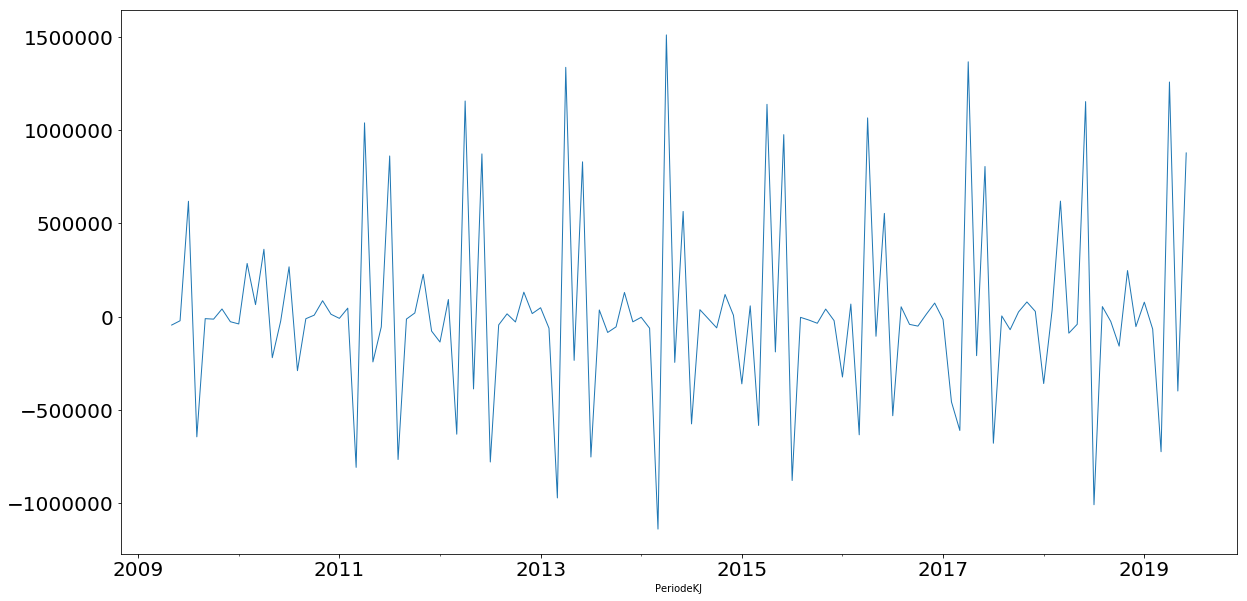

In [37]:
# Select features to be used in prediction
#features = {'A_B_Gesamt': df1.EUR, 'AE_Erloes': df2.Auftragseingang_Erlös, 'Planung_Fakt': df3.Gesamt, 'Umsatz_Erloes': df4.Erlös_Umsatz }
features = {'A_B_Gesamt': df1.EUR, 'AE_Erloes': df2.Auftragseingang_Erlös,  'Umsatz_Erloes': df4.Erlös_Umsatz,
           'Tonnen': df5.Tonnen, 'Erlös': df5.Erloes, 'Legierungszuschlag': df5.Legierungszuschlag,
           'Lohnkosten': df6.Lohnkosten, 'Gehaltskosten': df6.Gehaltskosten, 'Personalbeistellung': df6.Personalbeistellung,
           'EBIT': df7.EUR }

# Number of features
num_input = len(features)
# Number of output features
num_output = len(features)

dfc = pd.DataFrame(features).dropna()
dfc.Gehaltskosten.diff().plot(figsize=(20,10), linewidth=1, fontsize=20)
#plt.show()
#dfc.dropna()

In [38]:
for i in range(15):
    print(i,dfc.Lohnkosten.diff().autocorr(lag=i))

0 0.9999999999999999
1 -0.22686473291174697
2 -0.37602282228874706
3 -0.03741594538196825
4 0.05599189217207438
5 0.05471979453811788
6 0.04857645955118047
7 0.05345705502913674
8 0.09380036103771809
9 -0.06761917983804096
10 -0.4117330142422262
11 -0.07831349871468793
12 0.8216473137223387
13 -0.16248939772123477
14 -0.3998581826167288


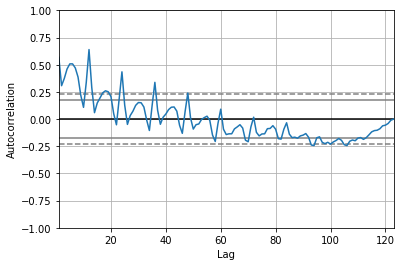

In [39]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(dfc.Lohnkosten)
#sm = autocorrelation_plot(dfc.Lohnkosten)
plt.show()

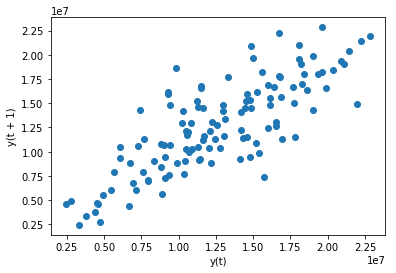

In [40]:
from pandas.plotting import lag_plot
lag_plot(dfc.Legierungszuschlag)

## Plot Datenreihe

In [41]:
data = []
d = {}
for ind, (key, value) in enumerate(features.items()):
    # Create trace to add to data
    trace = go.Scatter(x=value.index, y=value, name=key, yaxis='y{}'.format(ind+1))
    data.append(trace)
    # Create dictionaries for layout
    d['yaxis{}'.format(ind+2)] = {'overlaying': 'y', 'side': 'left'}
fig = go.Figure(data=data, layout=d)
# iplot(fig) does not work!
plot(fig)

'temp-plot.html'

In [42]:
df = pd.DataFrame(features)
df = dfc
df.head(3)

,A_B_Gesamt,AE_Erloes,Umsatz_Erloes,Tonnen,Erlös,Legierungszuschlag,Lohnkosten,Gehaltskosten,Personalbeistellung,EBIT
PeriodeKJ,,,,,,,,,,
2009-04-30,2600813.37,34644924.60,35069085.05,9188.62004,28400024.56,6649162.92,5614281.90,2567805.82,279321.23,-31338042.0
2009-05-31,2509739.44,18015933.92,31941715.91,6910.72017,27565660.30,4376002.56,4869528.11,2522576.69,222582.93,1894698.0
2009-06-30,2294888.57,20998588.54,30569297.60,6919.14975,26792471.82,3770893.45,6344876.47,2500349.05,282923.24,-305944.0


In [43]:
df.shape

(123, 10)

In [44]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In both the following tutorials, the first 300,000 rows of the data will be the training dataset, and there remaining will be the validation dataset. This amounts to ~2100 days worth of training data.

In [45]:
TRAIN_SPLIT = 100

Setting seed to ensure reproducibility.

In [46]:
#tf.random.set_seed(13)

## Part 1: Forecast a univariate time series
First, you will train a model using only a single feature (temperature), and use it to make predictions for that value in the future.

Let's first extract only the temperature from the dataset.

In [47]:
uni_data = df['Umsatz_Erloes']
#uni_data.index = df['PeriodeKJ']
uni_data.head()

PeriodeKJ
2009-04-30    35069085.05
2009-05-31    31941715.91
2009-06-30    30569297.60
2009-07-31    26044887.15
2009-08-31    20879473.62
Freq: M, Name: Umsatz_Erloes, dtype: float64

Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001775B1C53C8>],
      dtype=object)

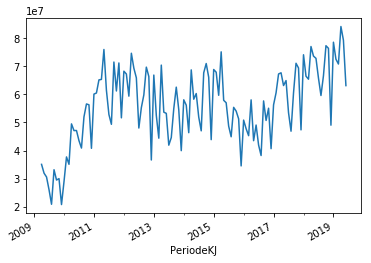

In [48]:
uni_data.plot(subplots=True)

In [49]:
uni_data = uni_data.values

It is important to normalize features before training a neural network. A common way to do so is by subtracting the mean and dividing by the standard deviation of each feature.

Note: The mean and standard deviation should only be computed using the training data.

In [50]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's normalize the data.

In [51]:
uni_data = (uni_data-uni_train_mean)/uni_train_std
print(uni_data.shape)

(123,)


Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

In [52]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)
print(x_train_uni.shape)

(80, 20, 1)


This is what the `univariate_data` function returns.

In [53]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.40455902]
 [-1.64947106]
 [-1.75694855]
 [-2.11126637]
 [-2.51578273]
 [-1.55377516]
 [-1.84089515]
 [-1.80127034]
 [-2.52389415]
 [-1.88537314]
 [-1.197215  ]
 [-1.40311531]
 [-0.27654934]
 [-0.46334441]
 [-0.46121124]
 [-0.74404104]
 [-0.94989833]
 [-0.08223543]
 [ 0.27838985]
 [ 0.2547966 ]]

 Target temperature to predict
-0.95740754396216


In [54]:
print ('Single window of past history')
print (x_val_uni[0])
print ('\n Target temperature to predict')
print (y_val_uni[0])

Single window of past history
[[-0.4805691 ]
 [ 0.58706184]
 [ 1.41179078]
 [ 1.2806087 ]
 [-0.44340963]
 [ 1.64890013]
 [ 1.05190487]
 [ 0.96842185]
 [ 1.87847406]
 [ 1.61212791]
 [ 1.54925883]
 [ 0.99909954]
 [ 0.51403821]
 [ 1.06549345]
 [ 1.90095251]
 [ 1.82786353]
 [-0.31278066]
 [ 1.99871196]
 [ 1.5252689 ]
 [ 1.39108031]]

 Target temperature to predict
2.4359766674720627


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [55]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [56]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Python36\\python-3.6.7.amd64\\lib\\site-packages\\matplotlib\\pyplot.py'>

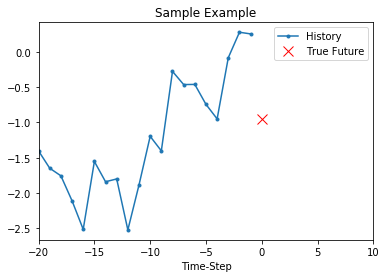

In [57]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [58]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Python36\\python-3.6.7.amd64\\lib\\site-packages\\matplotlib\\pyplot.py'>

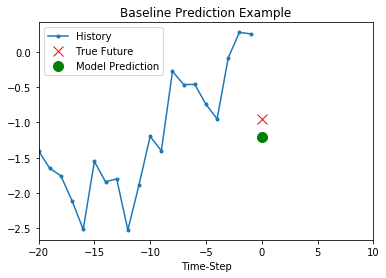

In [59]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Tem Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [60]:
BATCH_SIZE = 48
BUFFER_SIZE = 100

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

You will see the LSTM requires the input shape of the data it is being given. This shape can be inferred from dataset created.

In [65]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')
val_univariate

<RepeatDataset shapes: ((?, 20, 1), (?,)), types: (tf.float64, tf.float64)>

Let's make a sample prediction, to check the output of the model. 

In [66]:
#for x, y in val_univariate.take(1):
#    print(simple_lstm_model.predict(x).shape)
#train_univariate

In [71]:
x_val_uni.shape

(3, 20, 1)

In [72]:
simple_lstm_model.predict(x_val_uni)

array([[0.08683901],
       [0.0807212 ],
       [0.07875945]], dtype=float32)

Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [73]:
EVALUATION_INTERVAL = 20
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
20/20 [==============================] - 1s 52ms/step - loss: 0.6871 - val_loss: 1.5073
Epoch 2/10
20/20 [==============================] - 0s 13ms/step - loss: 0.6677 - val_loss: 1.3440
Epoch 3/10
20/20 [==============================] - 0s 13ms/step - loss: 0.6545 - val_loss: 1.2283
Epoch 4/10
20/20 [==============================] - 0s 13ms/step - loss: 0.6459 - val_loss: 1.1491
Epoch 5/10
20/20 [==============================] - 0s 13ms/step - loss: 0.6411 - val_loss: 1.0575
Epoch 6/10
20/20 [==============================] - 0s 14ms/step - loss: 0.6373 - val_loss: 1.0134
Epoch 7/10
20/20 [==============================] - 0s 13ms/step - loss: 0.6305 - val_loss: 1.0126
Epoch 8/10
20/20 [==============================] - 0s 13ms/step - loss: 0.6262 - val_loss: 1.0205
Epoch 9/10
20/20 [==============================] - 0s 13ms/step - loss: 0.6074 - val_loss: 1.0316
Epoch 10/10
20/20 [==============================] - 0s 13ms/step - loss: 0.5888 - val_loss: 1.0213


#### Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

In [74]:
#for x, y in val_univariate.take(3):
#  plot = show_plot([x[0].numpy(), y[0].numpy(),
#                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
#  plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

## Part 2: Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [75]:
features_considered = ['A_B_Gesamt','AE_Erloes','Umsatz_Erloes','Tonnen','Erlös','Legierungszuschlag','Lohnkosten','Gehaltskosten','Personalbeistellung','EBIT']



In [76]:
features = df[features_considered]
#features.index = df['Date Time']
features.head()

,A_B_Gesamt,AE_Erloes,Umsatz_Erloes,Tonnen,Erlös,Legierungszuschlag,Lohnkosten,Gehaltskosten,Personalbeistellung,EBIT
PeriodeKJ,,,,,,,,,,
2009-04-30,2600813.37,34644924.60,35069085.05,9188.62004,28400024.56,6649162.92,5614281.90,2567805.82,279321.23,-31338042.0
2009-05-31,2509739.44,18015933.92,31941715.91,6910.72017,27565660.30,4376002.56,4869528.11,2522576.69,222582.93,1894698.0
2009-06-30,2294888.57,20998588.54,30569297.60,6919.14975,26792471.82,3770893.45,6344876.47,2500349.05,282923.24,-305944.0
2009-07-31,2797804.04,20681620.48,26044887.15,5944.47010,22693714.67,3351007.87,3404329.35,3118913.89,360859.35,-6833605.0
2009-08-31,2634304.32,19753562.83,20879473.62,5260.39100,18437629.95,2441843.67,4441453.06,2474289.73,505288.62,-3202147.0


Let's have a look at how each of these features vary across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001775E5FEBA8>,
      dtype=object)

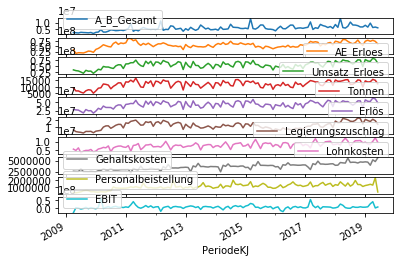

In [77]:
features.plot(subplots=True)

As mentioned, the first step will be to normalize the dataset using the mean and standard deviation of the training data.

In [78]:
dataset = features.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)
dataset

array([[  2600813.37,  34644924.6 ,  35069085.05, ...,   2567805.82,
           279321.23, -31338042.  ],
       [  2509739.44,  18015933.92,  31941715.91, ...,   2522576.69,
           222582.93,   1894698.  ],
       [  2294888.57,  20998588.54,  30569297.6 , ...,   2500349.05,
           282923.24,   -305944.  ],
       ...,
       [  6329658.41,  77915214.81,  84110253.32, ...,   5224673.37,
          1312587.14,  41682076.  ],
       [  6674177.4 ,  73118248.26,  79253658.29, ...,   4825863.24,
          2359070.68,    261258.  ],
       [  6103858.17,  61102374.19,  63087873.71, ...,   5703447.08,
           336784.72,   6694157.  ]])

In [79]:
dataset = (dataset-data_mean)/data_std
dataset

array([[-1.60320544, -1.55832491, -1.52342666, ..., -1.48527015,
        -2.05459142, -3.05192365],
       [-1.64885443, -2.75403039, -1.75286781, ..., -1.54795349,
        -2.19655075, -0.36666416],
       [-1.75654415, -2.53956299, -1.85355604, ..., -1.57875892,
        -2.04557918, -0.54447961],
       ...,
       [ 0.26580388,  1.55301986,  2.07450566, ...,  2.19689943,
         0.53064173,  2.84822076],
       [ 0.43848717,  1.20809458,  1.71819889, ...,  1.64418594,
         3.14894541, -0.49864877],
       [ 0.15262601,  0.34409467,  0.5321872 , ...,  2.86043495,
        -1.91081767,  0.02113994]])

### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [80]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In this tutorial, the network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days.  For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.

In [81]:
past_history = 24
future_target = 12
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.


In [82]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (4, 10)


In [83]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()
train_data_single

<RepeatDataset shapes: ((?, 4, 10), (?,)), types: (tf.float64, tf.float64)>

In [84]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Let's check out a sample prediction.

In [85]:
#for x, y in val_data_single.take(1):
#  print(single_step_model.predict(x).shape)

In [86]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL
                                            )

Epoch 1/10
20/20 [==============================] - 1s 39ms/step - loss: 0.5245
Epoch 2/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4653
Epoch 3/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4253
Epoch 4/10
20/20 [==============================] - 0s 3ms/step - loss: 0.3993
Epoch 5/10
20/20 [==============================] - 0s 3ms/step - loss: 0.3731
Epoch 6/10
20/20 [==============================] - 0s 3ms/step - loss: 0.3482
Epoch 7/10
20/20 [==============================] - 0s 3ms/step - loss: 0.3336
Epoch 8/10
20/20 [==============================] - 0s 3ms/step - loss: 0.3244
Epoch 9/10
20/20 [==============================] - 0s 2ms/step - loss: 0.3012
Epoch 10/10
20/20 [==============================] - 0s 3ms/step - loss: 0.2897


In [87]:
def plot_train_history(history, title):
  loss = history.history['loss']
  #val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  #plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

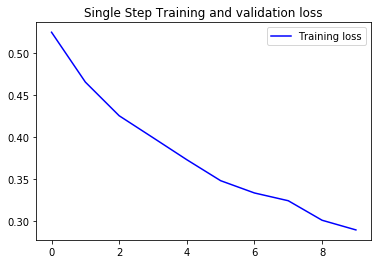

In [88]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction). 

In [89]:
#for x, y in val_data_single.take(3):
#  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
#                    single_step_model.predict(x)[0]], 12,
#                   'Single Step Prediction')
#  plot.show()

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [90]:
future_target = 12
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [91]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (4, 10)

 Target temperature to predict : (12,)


In [92]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [107]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

In [112]:
#for x, y in train_data_multi.take(1):
#  multi_step_plot(x[0], y[0], np.array([0]))
train_data_multi

<RepeatDataset shapes: ((?, 4, 10), (?, 12)), types: (tf.float64, tf.float64)>

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [113]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(12))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [114]:
#for x, y in val_data_multi.take(1):
#  print (multi_step_model.predict(x).shape)

In [ ]:
EPOCHS = 1000
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL)

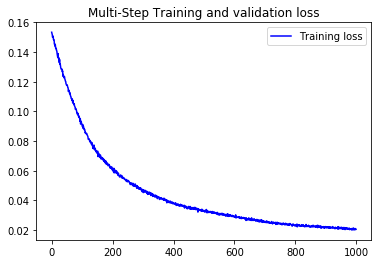

In [118]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

In [119]:
#for x, y in val_data_multi.take(3):
#    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])
multi_step_history

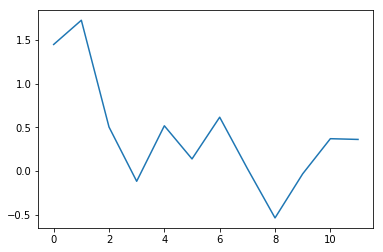

In [133]:
pred = multi_step_model.predict(x_train_multi)[0]
plt.plot(pred)

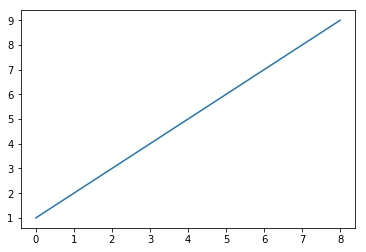

In [132]:
x = [1,2,3,4,5,6,7,8,9]

plt.plot(x)

## Next steps
This tutorial was a quick introduction to time series forecasting using an RNN. You may now try to predict the stock market and become a billionaire.

In addition, you may also write a generator to yield data (instead of the uni/multivariate_data function), which would be more memory efficient. You may also check out this [time series windowing](https://www.tensorflow.org/beta/guide/data#time_series_windowing) guide and use it in this tutorial.

For further understanding, you may read Chapter 15 of [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), 2nd Edition and Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).